In [1]:
# from scipy.optimize import curve_fit
# import pandas as pd
# import random
import sys, copy
# from IPython.display import clear_output
from matplotlib import pyplot as plt
from math import sqrt
from pprint import pprint


sys.path.append('../..')

# from model import run
# from model import plot_utils as pu
# from model import processing
from model.amm.omnipool_amm import OmnipoolState, execute_swap, execute_add_liquidity, usd_price, cash_out_omnipool, execute_remove_liquidity, lrna_price
from model.amm.agents import Agent
from model.amm.trade_strategies import price_manipulation, omnipool_arbitrage, price_manipulation_multiple_blocks
from model.amm.global_state import GlobalState, value_assets
# import model.amm.omnipool_amm as oamm




In [2]:
oracle_mult_list = [1]
# lp_multiplier_list = [0.01, 0.02, 0.05, 0.08, 0.1]
max_lp_mult = 0.5
max_lp_mult = 0.04
lp_steps = 10
lp_multiplier_list = [max_lp_mult / lp_steps * n for n in range(1, lp_steps+1)]
# trade_mult_list = [0.001, 0.002, 0.005, 0.01, 0.02]
# max_trade_mult = 0.02
# trade_steps = 20
# trade_mult_list = [max_trade_mult / trade_steps * n for n in range(1, trade_steps+1)]
max_price_move = 0.02
price_steps = 10
price_move_list = [max_price_move / price_steps * n for n in range(1, price_steps+1)]

max_lp_price_move_up = 20
lp_price_steps_up = 20
lp_price_move_list = [max_lp_price_move_up / lp_price_steps_up * n for n in range(1, lp_price_steps_up+1)]
max_inv_lp_price_move_down = 50
lp_price_steps_down = 5
lp_price_move_list_inv = [lp_price_steps_down * n / max_inv_lp_price_move_down for n in range(1, lp_price_steps_down+1)]
lp_price_move_list.extend(lp_price_move_list_inv)
lp_price_move_list.sort()

In [3]:
tokens = {
    'HDX': {'liquidity': 44000000, 'LRNA': 275143},
    # 'WETH': {'liquidity': 1400, 'LRNA': 2276599},
    'WETH': {'liquidity': 1400, 'LRNA': 546461},
    'DAI': {'liquidity': 2268262, 'LRNA': 2268262},
    # 'DOT': {'liquidity': 88000, 'LRNA': 546461},
    'DOT': {'liquidity': 88000, 'LRNA': 2276599},
    'WBTC': {'liquidity': 47, 'LRNA': 1145210},
}

prices = {tkn: tokens[tkn]['LRNA']/tokens[tkn]['liquidity'] for tkn in tokens}

# Profitability of add liquidity attack where asset is sold to the pool at manipulated price

In [4]:

profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]

            trade_mult = 1/sqrt(1 - price_move) - 1

            trade_size = tokens['DOT']['liquidity'] * trade_mult

            init_oracle = {
                'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                'volume_in': {tkn: 0 for tkn in tokens},
                'volume_out': {tkn: 0 for tkn in tokens},
                'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
            }

            omnipool: OmnipoolState = OmnipoolState(
                tokens=tokens,
                preferred_stablecoin='DAI',
                oracles={'price': 19, 'volatility': 19},
                last_oracle_values={
                    'price': copy.deepcopy(init_oracle),
                    'volatility': copy.deepcopy(init_oracle),
                },
                asset_fee = 0.0,
                lrna_fee = 0.0,
                withdrawal_fee = True,
                min_withdrawal_fee = 0.0001,
            )

            market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

            holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
            agent = Agent(holdings=holdings)

            swap_state, swap_agent = execute_swap(
                state=omnipool.copy(),
                agent=agent.copy(),
                tkn_sell='DOT',
                tkn_buy='DAI',
                sell_quantity=trade_size
            )

            # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
            # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
            # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

            add_state, add_agent = execute_add_liquidity(
                state=swap_state.copy(),
                agent=swap_agent.copy(),
                tkn_add='DOT',
                quantity=swap_state.liquidity['DOT'] * lp_multiplier
            )

            add_state2, add_agent2 = execute_add_liquidity(
                state=add_state.copy(),
                agent=add_agent.copy(),
                tkn_add='DAI',
                quantity=swap_state.liquidity['DAI'] * lp_multiplier
            )

            global_state = GlobalState(
                pools={'omnipool': add_state2},
                agents={'attacker': add_agent2},
                external_market=market_prices
            )

            arb_state = omnipool_arbitrage('omnipool', 20).execute(
                state=global_state.copy(),
                agent_id='attacker'
            )

            arbed_pool = arb_state.pools['omnipool']
            arbed_agent = arb_state.agents['attacker']

            remove_state, remove_agent = execute_remove_liquidity(
                state=arbed_pool.copy(),
                agent=arbed_agent.copy(),
                tkn_remove='DOT',
                quantity=arbed_agent.holdings[('omnipool', 'DOT')]
            )

            remove_state2, remove_agent2 = execute_remove_liquidity(
                state=remove_state.copy(),
                agent=remove_agent.copy(),
                tkn_remove='DAI',
                quantity=remove_agent.holdings[('omnipool', 'DAI')]
            )

            initial_value = cash_out_omnipool(omnipool, agent, market_prices)
            final_value = cash_out_omnipool(remove_state2, remove_agent2, market_prices)
            # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
            profits[i][j].append(final_value - initial_value)

        # price_moves[i][j] = max(price_moves[i][j])


In [5]:
max_profit = profits[0][0][0]
max_index = (0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            if profits[i][j][k] > max_profit:
                max_profit = profits[i][j][k]
                max_index = (i, j, k)

print(max_profit)
print(profits[max_index[0]][max_index[1]][max_index[2]])

-0.8984375
-0.8984375


In [6]:
# oracle_dataset = [profits[i][max_index[1]][max_index[2]] for i in range(len(oracle_mult_list))]
# lp_dataset = [profits[max_index[0]][i][max_index[2]] for i in range(len(lp_multiplier_list))]
# price_dataset = [profits[max_index[0]][max_index[1]][i] for i in range(len(price_move_list))]
# print(oracle_dataset)
# print(lp_dataset)
# print(trade_dataset)

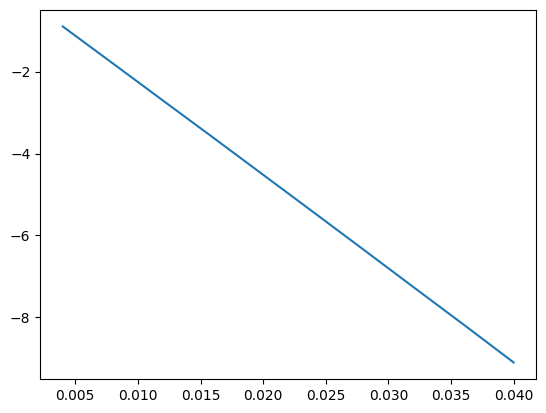

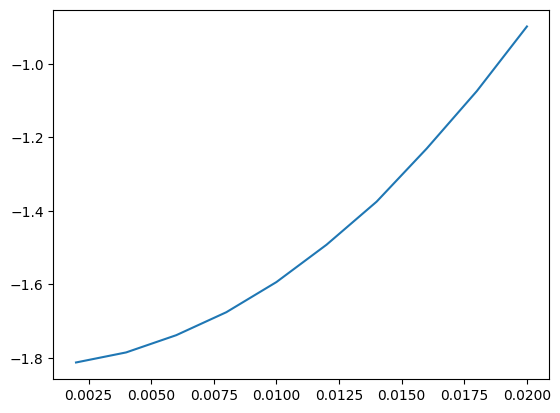

In [7]:
oracle_dataset = [profits[i][max_index[1]][max_index[2]] for i in range(len(oracle_mult_list))]
lp_dataset = [profits[max_index[0]][i][max_index[2]] for i in range(len(lp_multiplier_list))]
price_dataset = [profits[max_index[0]][max_index[1]][i] for i in range(len(price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, lp_dataset)
plt.show()
plt.plot(price_move_list, price_dataset)
plt.show()

In [8]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        data = [profits[i][k][j] for k in range(len(lp_multiplier_list))]
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = data
                break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)


lp multiplier profits are monotonic


In [9]:

# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        data = profits[i][j]
        # print(data)
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = copy.deepcopy(data)
                break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

print(price_move_list)




price move profits are monotonic
[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.02]


In [10]:
print(max_index)

(0, 0, 9)


In [11]:
print((lp_multiplier_list[max_index[1]], price_move_list[max_index[2]]))

(0.004, 0.02)


In [12]:
print(max_profit)

-0.8984375


# Profitability of add liquidity attack where asset is bought at manipulated price

In [13]:
buy_profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    buy_profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        buy_profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]

            trade_mult = 1 - 1/sqrt(1 + price_move)


            trade_size = tokens['DOT']['liquidity'] * trade_mult

            init_oracle = {
                'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                'volume_in': {tkn: 0 for tkn in tokens},
                'volume_out': {tkn: 0 for tkn in tokens},
                'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
            }

            omnipool: OmnipoolState = OmnipoolState(
                tokens=tokens,
                preferred_stablecoin='DAI',
                oracles={'price': 19, 'volatility': 19},
                last_oracle_values={
                    'price': copy.deepcopy(init_oracle),
                    'volatility': copy.deepcopy(init_oracle),
                },
                asset_fee = 0.0,
                lrna_fee = 0.0,
                withdrawal_fee = True,
                min_withdrawal_fee = 0.0001,
            )

            market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

            holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
            agent = Agent(holdings=holdings)

            swap_state, swap_agent = execute_swap(
                state=omnipool.copy(),
                agent=agent.copy(),
                tkn_buy='DOT',
                tkn_sell='DAI',
                buy_quantity=trade_size
            )

            # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
            # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
            # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

            add_state, add_agent = execute_add_liquidity(
                state=swap_state.copy(),
                agent=swap_agent.copy(),
                tkn_add='DOT',
                quantity=swap_state.liquidity['DOT'] * lp_multiplier
            )

            add_state2, add_agent2 = execute_add_liquidity(
                state=add_state.copy(),
                agent=add_agent.copy(),
                tkn_add='DAI',
                quantity=swap_state.liquidity['DAI'] * lp_multiplier
            )

            global_state = GlobalState(
                pools={'omnipool': add_state2},
                agents={'attacker': add_agent2},
                external_market=market_prices
            )

            arb_state = omnipool_arbitrage('omnipool', 20).execute(
                state=global_state.copy(),
                agent_id='attacker'
            )

            arbed_pool = arb_state.pools['omnipool']
            arbed_agent = arb_state.agents['attacker']

            remove_state, remove_agent = execute_remove_liquidity(
                state=arbed_pool.copy(),
                agent=arbed_agent.copy(),
                tkn_remove='DOT',
                quantity=arbed_agent.holdings[('omnipool', 'DOT')]
            )

            remove_state2, remove_agent2 = execute_remove_liquidity(
                state=remove_state.copy(),
                agent=remove_agent.copy(),
                tkn_remove='DAI',
                quantity=remove_agent.holdings[('omnipool', 'DAI')]
            )

            initial_value = cash_out_omnipool(omnipool, agent, market_prices)
            final_value = cash_out_omnipool(remove_state2, remove_agent2, market_prices)
            # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
            buy_profits[i][j].append(final_value - initial_value)

In [14]:
buy_max_profit = buy_profits[0][0][0]
buy_max_index = (0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            if buy_profits[i][j][k] > buy_max_profit:
                buy_max_profit = buy_profits[i][j][k]
                buy_max_index = (i, j, k)

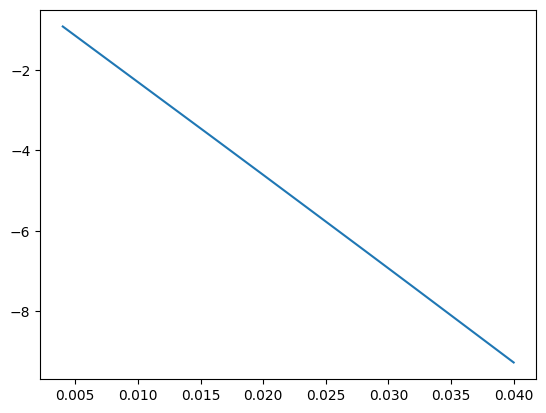

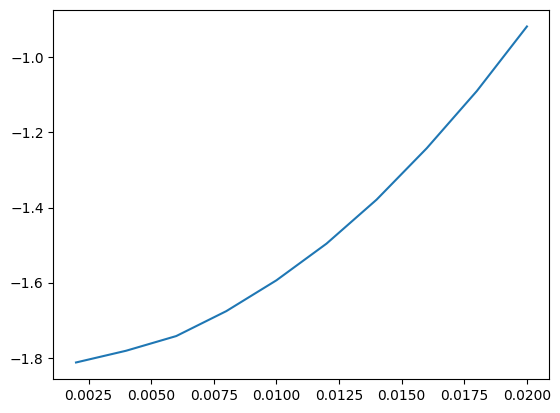

In [15]:
buy_oracle_dataset = [buy_profits[i][buy_max_index[1]][buy_max_index[2]] for i in range(len(oracle_mult_list))]
buy_lp_dataset = [buy_profits[buy_max_index[0]][i][buy_max_index[2]] for i in range(len(lp_multiplier_list))]
buy_price_dataset = [buy_profits[buy_max_index[0]][buy_max_index[1]][i] for i in range(len(price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, buy_lp_dataset)
plt.show()
plt.plot(price_move_list, buy_price_dataset)
plt.show()

In [16]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        data = [buy_profits[i][k][j] for k in range(len(lp_multiplier_list))]
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = data
                break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp multiplier profits are monotonic


In [17]:
# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        data = buy_profits[i][j]
        # print(data)
        for k in range(len(data) - 1):
            if data[k] * dir_sign >= data[k+1] * dir_sign:
                non_monotonic[(i,j)] = copy.deepcopy(data)
                break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    # pprint(non_monotonic)

print(price_move_list)


price move profits are monotonic
[0.002, 0.004, 0.006, 0.008, 0.01, 0.012, 0.014, 0.016, 0.018000000000000002, 0.02]


In [18]:
# print(profits[-1][20][-1])

In [19]:
# print(buy_profits[-1][20][-1])

# profitability of remove liquidity attack where asset is sold to manipulate price

In [20]:
lp_price_move = 1
profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]
            profits[i][j].append([])
            for l in range(len(lp_price_move_list)):

                lp_price_move = lp_price_move_list[l]

                trade_mult = 1/sqrt(1 - price_move) - 1

                trade_size = tokens['DOT']['liquidity'] * trade_mult

                init_oracle = {
                    'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                    'volume_in': {tkn: 0 for tkn in tokens},
                    'volume_out': {tkn: 0 for tkn in tokens},
                    'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
                }

                omnipool: OmnipoolState = OmnipoolState(
                    tokens=tokens,
                    preferred_stablecoin='DAI',
                    oracles={'price': 19, 'volatility': 19},
                    last_oracle_values={
                        'price': copy.deepcopy(init_oracle),
                        'volatility': copy.deepcopy(init_oracle),
                    },
                    asset_fee = 0.0,
                    lrna_fee = 0.0,
                    withdrawal_fee = True,
                    min_withdrawal_fee = 0.0001,
                )

                market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

                holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
                holdings[('omnipool', 'DOT')] = tokens['DOT']['liquidity'] * lp_multiplier
                share_prices = {('omnipool', 'DOT'): lrna_price(omnipool, 'DOT') * lp_price_move}
                agent = Agent(holdings=holdings, share_prices=share_prices)

                swap_state, swap_agent = execute_swap(
                    state=omnipool.copy(),
                    agent=agent.copy(),
                    tkn_sell='DOT',
                    tkn_buy='DAI',
                    sell_quantity=trade_size
                )

                # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
                # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
                # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

                remove_state, remove_agent = execute_remove_liquidity(
                    state=swap_state.copy(),
                    agent=swap_agent.copy(),
                    tkn_remove='DOT',
                    quantity=agent.holdings[('omnipool', 'DOT')]
                )

                global_state = GlobalState(
                    pools={'omnipool': remove_state},
                    agents={'attacker': remove_agent},
                    external_market=market_prices
                )

                arb_state = omnipool_arbitrage('omnipool', 20).execute(
                    state=global_state.copy(),
                    agent_id='attacker'
                )

                arbed_pool = arb_state.pools['omnipool']
                arbed_agent = arb_state.agents['attacker']

                initial_value = cash_out_omnipool(omnipool, agent, market_prices)
                final_value = cash_out_omnipool(arbed_pool, arbed_agent, market_prices)
                # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
                profits[i][j][k].append(final_value - initial_value)

        # price_moves[i][j] = max(price_moves[i][j])


In [21]:
max_profit = profits[0][0][0][0]
max_index = (0, 0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            for l in range(len(lp_price_move_list)):
                if profits[i][j][k][l] > max_profit:
                    max_profit = profits[i][j][k][l]
                    max_index = (i, j, k, l)

print(max_profit)
print(profits[max_index[0]][max_index[1]][max_index[2]][max_index[3]])

-2.4375
-2.4375


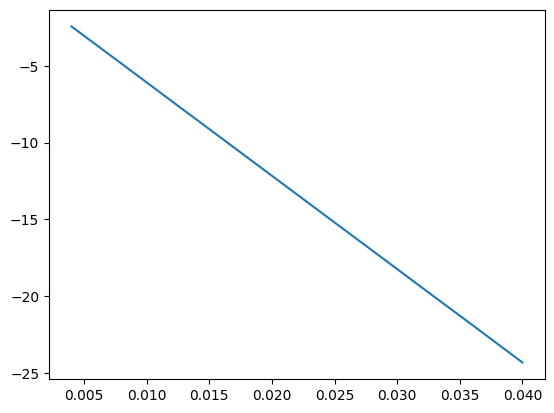

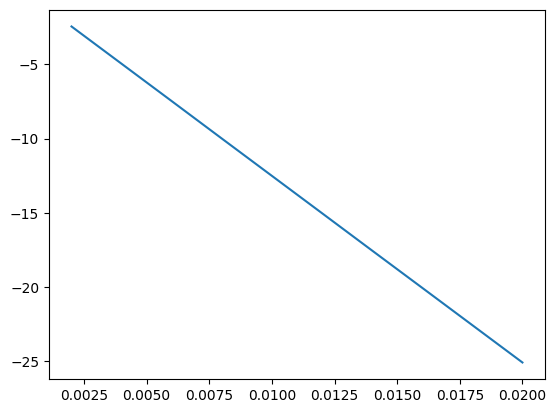

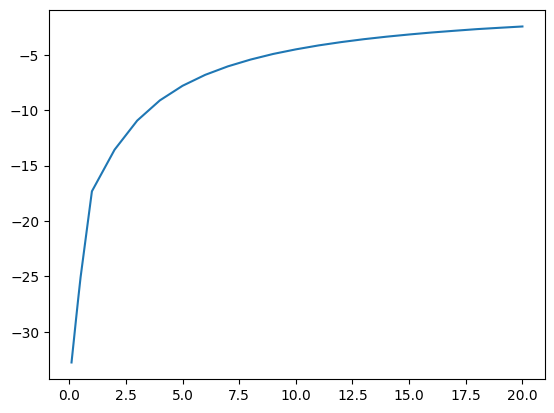

In [22]:
oracle_dataset = [profits[i][max_index[1]][max_index[2]][max_index[3]] for i in range(len(oracle_mult_list))]
lp_dataset = [profits[max_index[0]][i][max_index[2]][max_index[3]] for i in range(len(lp_multiplier_list))]
price_dataset = [profits[max_index[0]][max_index[1]][i][max_index[3]] for i in range(len(price_move_list))]
lp_price_dataset = [profits[max_index[0]][max_index[1]][max_index[2]][i] for i in range(len(lp_price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, lp_dataset)
plt.show()
plt.plot(price_move_list, price_dataset)
plt.show()
plt.plot(lp_price_move_list, lp_price_dataset)
plt.show()

In [23]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][l][j][k] for l in range(len(lp_multiplier_list))]
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp multiplier profits are monotonic


In [24]:

# Test monotonicity of price move
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][j][l][k] for l in range(len(price_move_list))]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

price move profits are monotonic


In [25]:

# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with lp price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            data = profits[i][j][k]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('lp price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp price move profits are monotonic


In [26]:
lp_price_move = 1
profits = []
# price_moves = []
for i in range(len(oracle_mult_list)):
    oracle_mult = oracle_mult_list[i]
    profits.append([])
    # price_moves.append([])
    for j in range(len(lp_multiplier_list)):
        lp_multiplier = lp_multiplier_list[j]
        profits[i].append([])
        # price_moves[i].append([])
        for k in range(len(price_move_list)):
            price_move = price_move_list[k]
            profits[i][j].append([])
            for l in range(len(lp_price_move_list)):

                lp_price_move = lp_price_move_list[l]

                trade_mult = 1 - 1/sqrt(1 + price_move)

                trade_size = tokens['DOT']['liquidity'] * trade_mult

                init_oracle = {
                    'liquidity': {tkn: tokens[tkn]['liquidity'] for tkn in tokens},
                    'volume_in': {tkn: 0 for tkn in tokens},
                    'volume_out': {tkn: 0 for tkn in tokens},
                    'price': {tkn: oracle_mult * prices[tkn] for tkn in tokens},
                }

                omnipool: OmnipoolState = OmnipoolState(
                    tokens=tokens,
                    preferred_stablecoin='DAI',
                    oracles={'price': 19, 'volatility': 19},
                    last_oracle_values={
                        'price': copy.deepcopy(init_oracle),
                        'volatility': copy.deepcopy(init_oracle),
                    },
                    asset_fee = 0.0,
                    lrna_fee = 0.0,
                    withdrawal_fee = True,
                    min_withdrawal_fee = 0.0001,
                )

                market_prices = {tkn: usd_price(omnipool, tkn) for tkn in omnipool.asset_list}

                holdings = {tkn: 1000000000 for tkn in omnipool.asset_list}
                holdings[('omnipool', 'DOT')] = tokens['DOT']['liquidity'] * lp_multiplier
                share_prices = {('omnipool', 'DOT'): lrna_price(omnipool, 'DOT') * lp_price_move}
                agent = Agent(holdings=holdings, share_prices=share_prices)

                swap_state, swap_agent = execute_swap(
                    state=omnipool.copy(),
                    agent=agent.copy(),
                    tkn_buy='DOT',
                    tkn_sell='DAI',
                    buy_quantity=trade_size
                )

                # manipulated_price = swap_state.lrna['DOT'] / swap_state.liquidity['DOT']
                # init_spot_price = omnipool.lrna['DOT'] / omnipool.liquidity['DOT']
                # price_moves[i][j].append((init_spot_price - manipulated_price) / init_spot_price)

                remove_state, remove_agent = execute_remove_liquidity(
                    state=swap_state.copy(),
                    agent=swap_agent.copy(),
                    tkn_remove='DOT',
                    quantity=agent.holdings[('omnipool', 'DOT')]
                )

                global_state = GlobalState(
                    pools={'omnipool': remove_state},
                    agents={'attacker': remove_agent},
                    external_market=market_prices
                )

                arb_state = omnipool_arbitrage('omnipool', 20).execute(
                    state=global_state.copy(),
                    agent_id='attacker'
                )

                arbed_pool = arb_state.pools['omnipool']
                arbed_agent = arb_state.agents['attacker']

                initial_value = cash_out_omnipool(omnipool, agent, market_prices)
                final_value = cash_out_omnipool(arbed_pool, arbed_agent, market_prices)
                # profit_dict[(oracle_mult, lp_multiplier, trade_mult)] = final_value - initial_value
                profits[i][j][k].append(final_value - initial_value)

In [27]:
max_profit = profits[0][0][0][0]
max_index = (0, 0, 0, 0)
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            for l in range(len(lp_price_move_list)):
                if profits[i][j][k][l] > max_profit:
                    max_profit = profits[i][j][k][l]
                    max_index = (i, j, k, l)

print(max_profit)
print(profits[max_index[0]][max_index[1]][max_index[2]][max_index[3]])

-0.8671875
-0.8671875


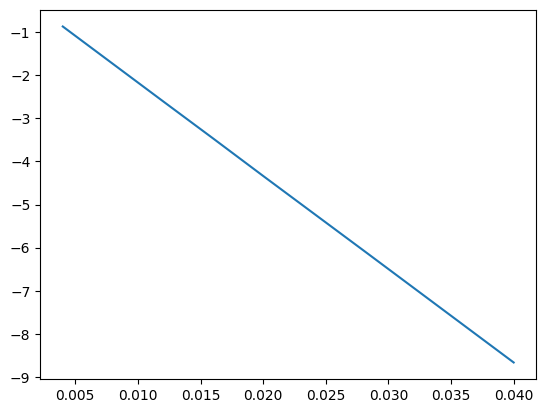

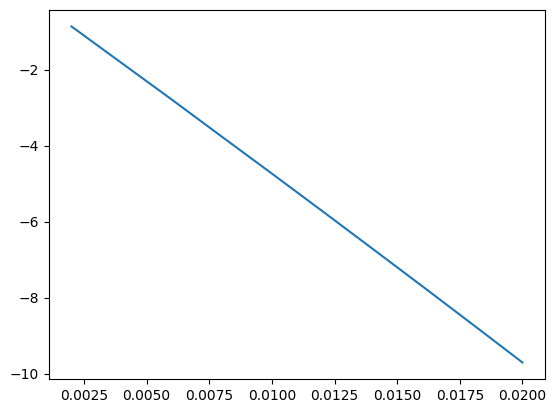

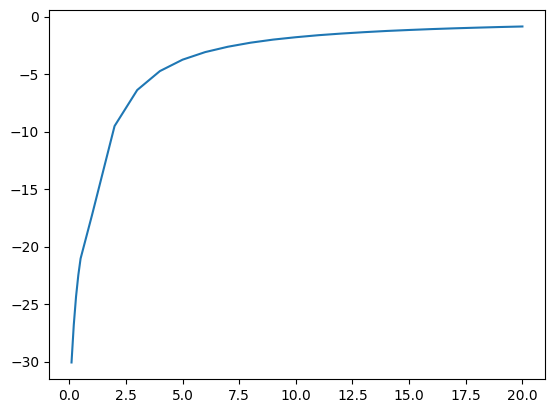

In [28]:
oracle_dataset = [profits[i][max_index[1]][max_index[2]][max_index[3]] for i in range(len(oracle_mult_list))]
lp_dataset = [profits[max_index[0]][i][max_index[2]][max_index[3]] for i in range(len(lp_multiplier_list))]
price_dataset = [profits[max_index[0]][max_index[1]][i][max_index[3]] for i in range(len(price_move_list))]
lp_price_dataset = [profits[max_index[0]][max_index[1]][max_index[2]][i] for i in range(len(lp_price_move_list))]

# plt.plot(oracle_mult_list, oracle_dataset)
# plt.show()
plt.plot(lp_multiplier_list, lp_dataset)
plt.show()
plt.plot(price_move_list, price_dataset)
plt.show()
plt.plot(lp_price_move_list, lp_price_dataset)
plt.show()

In [29]:

# Test monotonicity of lp multiplier
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with lp multiplier
for i in range(len(oracle_mult_list)):
    for j in range(len(price_move_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][l][j][k] for l in range(len(lp_multiplier_list))]
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break
if len(non_monotonic) == 0:
    print('lp multiplier profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp multiplier profits are monotonic


In [30]:
# Test monotonicity of price move
non_monotonic = {}
dir_sign = -1  # we expect profit to decrease with price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(lp_price_move_list)):
            data = [profits[i][j][l][k] for l in range(len(price_move_list))]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

price move profits are monotonic


In [31]:
# Test monotonicity of price move
non_monotonic = {}
dir_sign = 1  # we expect profit to increase with lp price move
for i in range(len(oracle_mult_list)):
    for j in range(len(lp_multiplier_list)):
        for k in range(len(price_move_list)):
            data = profits[i][j][k]
            # print(data)
            for l in range(len(data) - 1):
                if data[l] * dir_sign >= data[l+1] * dir_sign:
                    non_monotonic[(i,j,k)] = data
                    break

if len(non_monotonic) == 0:
    print('lp price move profits are monotonic')
else:
    print('Non-monotonic data found')
    pprint(non_monotonic)

lp price move profits are monotonic
